#### Summary

- Более-менее приемлемый результат с Unet-5 и исходными данными в форме 64х64х1.

- Результат в initial_weights_600foils_04122020.h5, val_loss = 4.179015103318306e-05

- Внизу есть подробный текст с описанием того, как что делалось.

In [2]:
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from lib.preprocess_modules import load_pkl, save_pkl
from lib.dl_modules import *
from config import *
from pathlib import Path
from numpy.random import shuffle, seed
import gc
import matplotlib.pyplot as plt
import os

In [18]:
'''
Generate final dataset from separate files.
X: array of n_files*
y: array of n_files*
Save to pkl files.
'''

n_files=138
X = np.zeros((n_files, 64, 64, 1))
y = np.zeros((n_files, 128))

sample=0
for fname in os.listdir(foils_pkl_path): # сперва нужные профили
    if sample>n_files-1:break
    if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:
        foil = load_pkl(Path(foils_pkl_path, fname))
        X[sample, :, :, :] = foil['X'].reshape(64, 64, 1)
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1

for fname in os.listdir(foils_pkl_path): # потом все оставшиеся
    if sample>n_files-1:break
    if fname[:2].lower() not in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht', 'X.', 'y.']:
        foil = load_pkl(Path(foils_pkl_path, fname))
        X[sample, :, :, :] = foil['X'].reshape(64, 64, 1)
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1
    
assert np.sum(np.isnan(X))==0, "NaNs in X"
assert np.sum(np.isnan(y))==0, "NaNs in y"

save_pkl(X, Path(foils_pkl_path, "X.pkl"))
save_pkl(y, Path(foils_pkl_path, "y.pkl"))

print("Totally foils in arrays: %i" % (sample))

Totally foils in arrays: 138


In [19]:
X = load_pkl(Path(foils_pkl_path, 'X.pkl'))
y = load_pkl(Path(foils_pkl_path, 'y.pkl'))
X.shape, y.shape

((138, 64, 64, 1), (138, 128))

In [20]:
all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

In [22]:
def define_unet_5(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
       
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (3,3), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (1,1), activation='tanh', padding='same')(conv5)

    flat = Flatten()(conv5)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model



model = define_unet_5(input_shape=(64,64,1), optimizer=Adam(1), lr=1e-4, reg=1e-2)

U-Net compiled
Input shape: (None, 64, 64, 1)
Output shape: (None, 128)


In [30]:
# training
gc.collect()

n_epochs=1
batch_size=1
lr=1e-5
reg=0.001
optimizer=Adam(learning_rate=lr)

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=batch_size, Xdim=X[0].shape, shuffle=False)

model = define_unet_5(input_shape=X[0].shape, optimizer=optimizer, lr=lr, reg=reg)

model.load_weights(str(Path("./weights", 'initial_weights_600foils_04122020.h5')))

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')

U-Net compiled
Input shape: (None, 64, 64, 1)
Output shape: (None, 128)
103/103 [==============================] - 10s 96ms/step - loss: 1.0637e-05 - mse: 1.0637e-05 - val_loss: 9.5429e-06 - val_mse: 9.5429e-06
Done.


0.060246386


[]

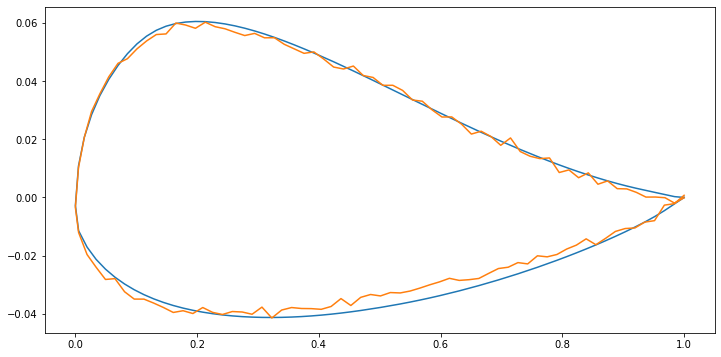

In [46]:
X_pred, y_targ = test_generator[12]
X_pred = X_pred[0]
y_targ = y_targ[0]
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
print(np.max(y_pred))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, y_targ), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

#### Выстрелила model5 - только contracting path от Unet

### Как получил начальные веса

#### Шаг 1 - тренировка на 138 профилях группы ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]
138 штук
n_epochs=10000
batch_size=1
lr=1e-4
reg=0.1
optimizer=Adam(learning_rate=lr)
model5

Результат сохранен в 'initial_weights_138foils_04122020.h5'- для профилей группы ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ], 

#### шаг 2 - 300 первых профилей по списку
подгрузил веса с предыдущего шага
n_epochs=1000
batch_size=1
lr=1e-5
reg=0.1

val_loss = 7.844471713522379e-05

Результат в initial_weights_300foils_04122020.h5

#### шаг 3 - 600 первых профилей по списку
подгрузил веса с предыдущего шага
n_epochs=1000
batch_size=1
lr=1e-5
reg=0.1

val_loss = 4.179015103318306e-05

Результат в initial_weights_600foils_04122020.h5


##### TODO
- интересно, а с нуля сможет зохавать все профили или упадёт? падает
- определить наилучший batch_size - 1
- добавить фильтров 4х4
- добавить еще пару сверточных - блоков получше
- уменьшить число каналов - шляпа
- попробовать другие активации - не выстрелило
- другой лосс? - подумать
- регуляризацию подобрать, вроде больше-лучше 0.1...0.001 самое то
- SGD плохо